In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.



In [ ]:
#Load the csv files 
os.chdir("../input")
df1=pd.read_csv('heroes_information.csv')
df2=pd.read_csv('super_hero_powers.csv')

Let's do some data exploration

In [ ]:
df1.info()

In [ ]:
df1.head()

In [ ]:
df2.info()

In [ ]:
df2.head()

So what we have here is the features and characeristics of each super hero in the first dataset (with height, weight, publisher, hair color, eye color etc. ) and the super hero powers represented by 168 boolean variables in the second dataset.

Let's dive into this more!


***Heroes Information***


Let's look at the type of publishers

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
sns.set_style('dark')
plt.subplots(figsize=(20,10))
ax=sns.countplot(x='Publisher',data=df1,palette='husl')
ax.set_xticklabels(ax.get_xticklabels(),rotation=40)

In [ ]:
df1=df1.drop("Unnamed: 0",axis=1) #dropping unnecessary columns

In [ ]:
#Replacing hyphen with 'unknown' for missing values
labels=['Gender','Eye color','Race','Hair color','Skin color','Alignment','Publisher']
df1[labels]=df1[labels].replace('-','Unknown')


In [ ]:
df1[labels]=df1[labels].apply(lambda x:x.astype('category'),axis=0)
unique_cat=df1[labels].apply(pd.Series.nunique,axis=0)

In [ ]:
unique_cat.plot(kind='bar',figsize=(10,10))

The above graph depicts the categories under each variable and it looks like the race variable with the maximum number of categories

**Height and Weight**
![](http://)Now, let's examine the height and weight characteristics

In [ ]:
df1.describe()

Now, let us examine the relationship between height and weight using a pairplot

In [ ]:
sns.pairplot(data=df1,vars=['Height','Weight'],kind='scatter',hue='Gender',palette='bright',diag_kws={'alpha':.5})

looks like the height becomes a constant after a point no matter whatever the weights of the heroes be.

**Body Mass Index and Body type**

Using heights and weights, let us create a new feature called body mass index.

bmi= weight (in lbs) * 703/(height (in inches))^2

In [ ]:
#calculate body mass index using height and weight
df1['Height']=df1['Height']*0.393701     #converting cm to inches
df1['bmi']=(df1['Weight']*703)/(df1['Height']**2)


Using the bmi feature let us create a new feature called body type which are categorized based on the bmi scores
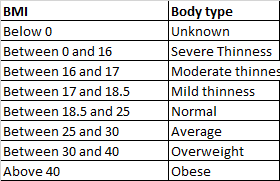

In [ ]:
df1.loc[(df1.bmi<0),'body_type']='Unknown'
df1.loc[(df1.bmi>0) & (df1.bmi<16),'body_type']='Severe thinness'
df1.loc[(df1.bmi>16) & (df1.bmi<=17),'body_type']='Moderate thinness'
df1.loc[(df1.bmi>17) & (df1.bmi<=18.5),'body_type']='Mild thinness'
df1.loc[(df1.bmi>18.5) & (df1.bmi<=25),'body_type']='Normal'
df1.loc[(df1.bmi>25) & (df1.bmi<=30),'body_type']='Average'
df1.loc[(df1.bmi>30) & (df1.bmi<=40),'body_type']='Overweight'
df1.loc[(df1.bmi>=40),'body_type']='Obese'


In [ ]:
sns.set_style("whitegrid")
plt.subplots(figsize=(10,5))
sns.heatmap(pd.crosstab(df1['Alignment'],df1['Gender']))

As seen from the heatmap,the gender and alignment seem to be proportional with each other

In [ ]:
plt.subplots(figsize=(15,5))
sns.countplot(x='body_type',data=df1,palette='Paired')

There are many heroes whose body type is below normal as per the graph

In [ ]:
#Examining race and body type
sns.set_style("dark")
plt.subplots(figsize=(10,10))
sns.heatmap(pd.crosstab(df1['Race'],df1['body_type']),cmap="PiYG")

It is so surprising that even humans are below normal for a standard human body mass index. Maybe that is fine in the world of  superheroes I suppose! 

**Superhero powers**

Now, let's move on to our next dataset!

As we saw earlier, this dataset comprises of the superhero powers which is basically a checklst with 168 list of indicators. We can probably merge this data with the previous one to predict the other missing elements like alignment or any other type of characteristics of a hero. 

In [ ]:
df2.head()

But the trouble here is we only have the names of the heroes as the merging key and there are 19 duplicate names in the information dataset. So our first step will be to remove these duplicates rows

In [ ]:
df1['name'].duplicated().sum()

In [ ]:
df1=df1.drop_duplicates(subset='name')

Combining both datasets with setting name as the index and removing all the columns from the first dataset except for alignment because we are going to classify the alignment of the heroes based on their superpowers. 

In [ ]:
df=df1.set_index('name').join(df2.set_index('hero_names'))

In [ ]:
df=df.drop(df1.drop(['name','Alignment'],axis=1).columns,axis=1)

So this is how our dataset looks like !

In [ ]:
df.head()

In [ ]:
df=df.dropna(thresh=2) #dropping all rows with more than 2 missing values

In [ ]:
dfnew=df[~(df['Alignment']=='Unknown')]  #Create a dataset where the alignment is known (this data is used for running and testing the model)
new_data=df[df['Alignment']=='Unknown'] #Create a dataset where the alignment is unknown (Let's set aside this data)

In [ ]:
from sklearn.model_selection import train_test_split #importing train test split to split the data for validation


In [ ]:
X=dfnew.drop('Alignment',axis=1)
y=dfnew['Alignment']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

**K-Nearest neigbors**

We will use the KNN for classification here and since we don't know the exact number of neighbors to set, we will run a loop with some possible neighbor value ranges

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:

neighbors=np.arange(1,20)           #setting the possible neighbor values
train_acc=np.empty(len(neighbors))   #Initialize empty array for storing training accuracy
test_acc=np.empty(len(neighbors))    #Initialize empty array for storing training accuracy

    

In [ ]:
#Run a for loop with KNN model for each neighbor and store the training and testing accuracy for each iteration
for i,k in enumerate(neighbors):
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    train_acc[i]=knn.score(X_train,y_train)
    test_acc[i]=knn.score(X_test,y_test)
    

In [ ]:
# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_acc, label = 'Testing Accuracy')
plt.plot(neighbors, train_acc, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()


As seen from the graph, the training and testing accuracy are closer when there are more than 10 neighbors. Though the accuracy score is only around 60%, it is the highest the testing accuracy has ever achieved. So, let's go with 15 neighbors

**Predict new data**

let's predict the missing alignment data which we have set aside using the KNN model with 13 neighbors

In [ ]:
newmodel=KNeighborsClassifier(n_neighbors=13)
newmodel.fit(X_train,y_train)


In [ ]:
newmodel.score(X_test,y_test)

In [ ]:
new_data['Alignment_predict']=newmodel.predict(new_data.drop('Alignment',axis=1))

In [ ]:
new_data['Alignment_predict']

Thanks!